# Static Map

PyPSA has a built-in method to map parameters and results in a static plot using `n.plot()`. For interactive maps, please see [Interactive Maps](/user-guide/plotting/plotting-maps-interactive)

## Input data

In [1]:
import geopandas as gpd

import pypsa

n = pypsa.examples.scigrid_de()

INFO:pypsa.network.io:Retrieving network data from https://github.com/PyPSA/PyPSA/raw/v1.0.0rc1/examples/networks/scigrid-de/scigrid-de.nc.
INFO:pypsa.network.io:Imported network 'SciGrid-DE' has buses, carriers, generators, lines, loads, storage_units, transformers


## Preparation

For illustrative purposes and a simpler postprocessing workflow, we cluster the network based on federal states. For a more detailed guide on clustering, please go to [Network Clustering](/examples/clustering). Within the scope of this guide, you can ignore the following blocks.

In [2]:
n.calculate_dependent_values()
n.lines = n.lines.reindex(columns=n.components["Line"]["attrs"].index[1:])
n.lines["type"] = "Al/St 240/40 2-bundle 220.0"
n.buses = n.buses.reindex(columns=n.components["Bus"]["attrs"].index[1:])
n.buses["frequency"] = 50

In [3]:
url = "https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/9469f09592ced973a3448cf66b6100b741b64c0d/releaseData/gbOpen/DEU/ADM1/geoBoundaries-DEU-ADM1-all.zip"
states = gpd.read_file(url, layer="geoBoundaries-DEU-ADM1_simplified")
states["shapeName"] = states["shapeName"].apply(
    lambda x: x.encode("latin1").decode("utf-8")
)  # fix encoding issue

In [4]:
bus_coords = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(n.buses.x, n.buses.y, crs=4326), index=n.buses.index
)
busmap = bus_coords.to_crs(3035).sjoin_nearest(states.to_crs(3035), how="left").shapeISO
nc = n.cluster.cluster_by_busmap(busmap)

By default, calling `n.plot()` will render all network components based on the `x` and `y` coordinates defined in `n.buses`. This allows us to get a first visual overview on the two networks, before and after clustering.

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x7f698ae45b50>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x7f698ad8e1b0>,
  'Transformer': <matplotlib.collections.LineCollection at 0x7f698ac00d70>},
 'flows': {}}

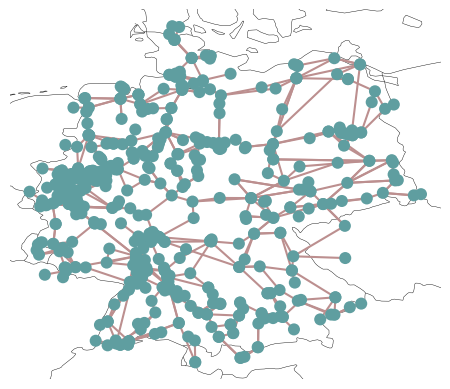

In [5]:
n.plot()

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x7f698ae7b440>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x7f698aed0e00>},
 'flows': {}}

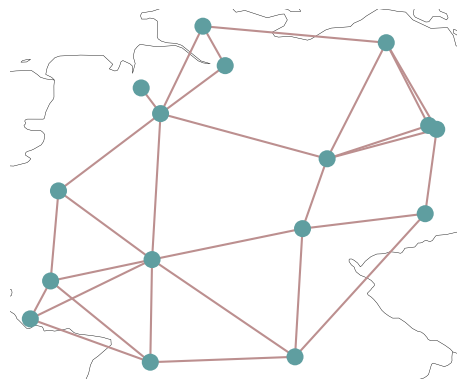

In [6]:
nc.plot()

## Mapping results

To map result to parameters of `n.plot()`, we first solve the network and then use `n.statistics()` to calculate relevant metrics.

In [7]:
# We reduce logging output for clarity
import logging

logging.getLogger("pypsa").setLevel(logging.ERROR)
logging.getLogger("linopy").setLevel(logging.ERROR)

nc.optimize()

Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 59.99it/s]


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-_0986biz has 76872 rows; 37608 cols; 117490 nonzeros
Coefficient ranges:
  Matrix [4e-01, 9e+01]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [2e-11, 2e+04]
Presolving model
1656 rows, 27772 cols, 32438 nonzeros  0s
1512 rows, 5899 cols, 10325 nonzeros  0s
Dependent equations search running on 1488 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
1488 rows, 5875 cols, 10459 nonzeros  0s
Presolve : Reductions: rows 1488(-75384); columns 5875(-31733); elements 10459(-107031)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.1463614410e+00 Pr: 576(1.25327e+07) 0s
       2284     4.6934521029e+06 Pr: 0(0); Du: 0(1.02802e-12) 0s
Solving the original LP from the solution after postsolve
Model name          : l

('ok', 'optimal')

From above we learned that `bus_sizes` accepts parameters of type `float`, `dict`, and `pd.Series`. When passing a multi-index `pd.Series`, its values will be mapped to pie chart slices.

In [8]:
eb = nc.statistics.energy_balance(
    groupby=["bus", "carrier"],
    aggregate_across_components=True,
    comps=["Generator", "Load", "StorageUnit"],
)

We also extract branch results, e.g., line and link flows in this example.

In [9]:
line_flow = nc.lines_t.p0.sum(axis=0)
link_flow = nc.links_t.p0.sum(axis=0)

### Carrier colors

Note that for the pie slices to be plotted and colored correctly, passing a multi-index `pd.Series` requires all carrier colors to exist. Colors can be specified by their hex code representation or from the list of matplotlib names (see https://matplotlib.org/stable/gallery/color/named_colors.html). In `n.statistics.energy_balance` load is also included, so we also need to include the a color for the load carrier.

In [10]:
colors = {
    "Multiple": "pink",
    "AC": "black",
    "Brown Coal": "saddlebrown",
    "Gas": "darkorange",
    "Geothermal": "firebrick",
    "Hard Coal": "darkslategray",
    "Nuclear": "mediumorchid",
    "Oil": "peru",
    "Other": "dimgray",
    "Pumped Hydro": "cornflowerblue",
    "Run of River": "royalblue",
    "Solar": "gold",
    "Storage Hydro": "navy",
    "Waste": "olive",
    "Wind Offshore": "teal",
    "Wind Onshore": "turquoise",
}

nc.carriers.color = nc.carriers.index.map(colors)

As the carriers for loads are missing, we need to add them, manually.

In [11]:
nc.carriers.loc["", "color"] = "darkred"
nc.carriers.loc["-", "color"] = "darkred"

### Plotting balances and flow

We first choose a suitable projection for the plot by importing `cartopy` and `matplotlib`. Commonly used projections include `ccrs.Mercator()` or `ccrs.EqualEarth()`. We can also pass `geomap_colors=True` to get default colorings for land and water bodies. Note that this requires cartopy to be installed.

In [34]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x7f698ac68a40>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x7f698aca9e80>},
 'flows': {}}

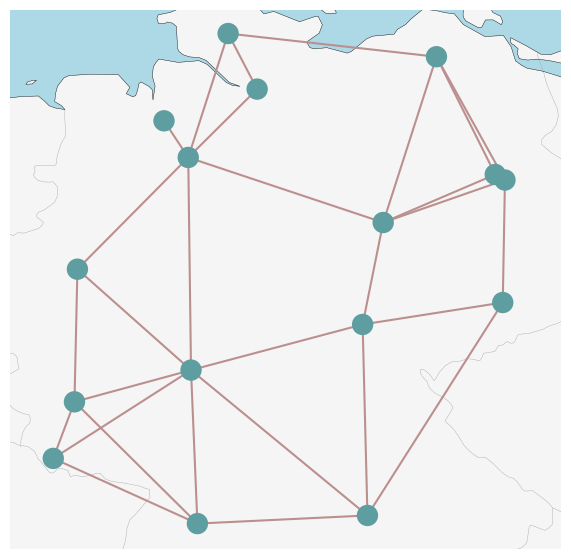

In [35]:
fig, ax = plt.subplots(
    figsize=(8, 7), subplot_kw={"projection": ccrs.EqualEarth()}
)
nc.plot(ax=ax, geomap_colors=True)

Next, let's pass the results to `n.explore()`. Setting `bus_split_circles=True` maps negative values to the bottom half and positive values to the positive half. If set to `False`, bottom half circles are not used and negative values will automatically be omitted. Note that the area of `bus_sizes` scales proportionally to the values passed. To get a useful map, we need to scale the values, according to personal preference.

In [36]:
bus_size_factor = 3e6
branch_width_factor = 2e4
branch_flow_factor = 5e4

In [37]:
nc.plot(
    ax=ax,
    bus_sizes=eb/bus_size_factor,
    bus_split_circles=True,
    line_widths=line_flow/branch_width_factor,
    link_widths=link_flow/branch_width_factor,
    line_flow=line_flow/branch_flow_factor,
)

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x7f6989286420>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x7f698ac89e80>},
 'flows': {'Line': <matplotlib.collections.PatchCollection at 0x7f698aca8aa0>}}

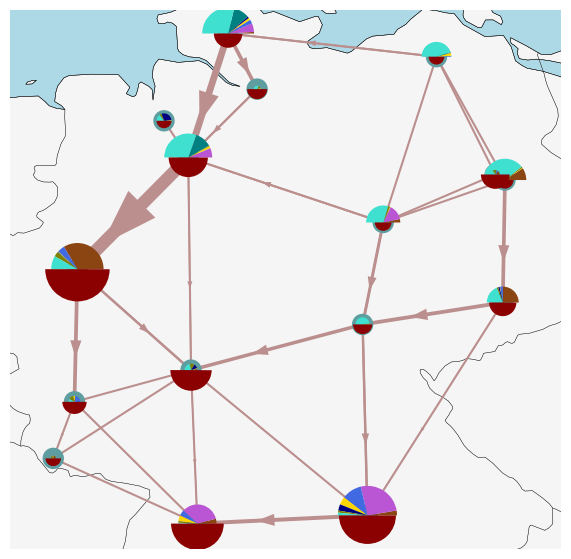

In [38]:
fig

### Adding legends

We import additional functions from `pypsa.plot` to add legends to our figure. It makes sense to select values that are close to values represented in the figure, e.g. the maximum, minimum values and something in between.

In [39]:
from pypsa.plot import add_legend_lines, add_legend_patches, add_legend_semicircles

In [40]:
print(f"Max flow: {line_flow.abs().max()}")
print(f"Min flow: {line_flow.abs().min()}")

Max flow: 181341.97489722894
Min flow: 62.45143026589699


Based on the values, we choose the following. Not that the values need to be scaled with the same factors determined before.

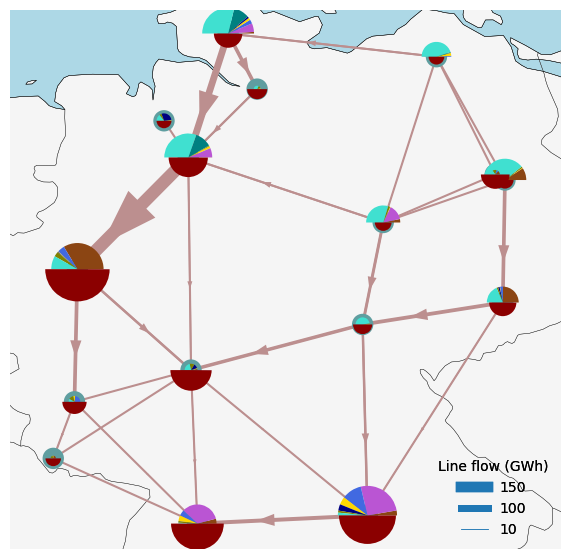

In [41]:
add_legend_lines(
    ax,
    sizes=[branch/branch_width_factor for branch in [150000,100000,10000]],
    labels=["150", "100", "10"],
    legend_kw={"loc": "lower right", "frameon": False, "title": "Line flow (GWh)"}
)
fig

Now we apply the same process for bus sizes.

In [42]:
print(f"Max gen./load: {eb.groupby("bus").sum().abs().max()}")
print(f"Max gen./load: {eb.groupby("bus").sum().abs().min()}")


Max gen./load: 123128.39888000001
Max gen./load: 62.45143000000007


/tmp/ipykernel_91931/3935741764.py:1: UserWarning:

When combining n.plot() with other plots on a geographical axis, ensure n.plot() is called first or the final axis extent is set initially (ax.set_extent(boundaries, crs=crs)) for consistent legend semicircle sizes.



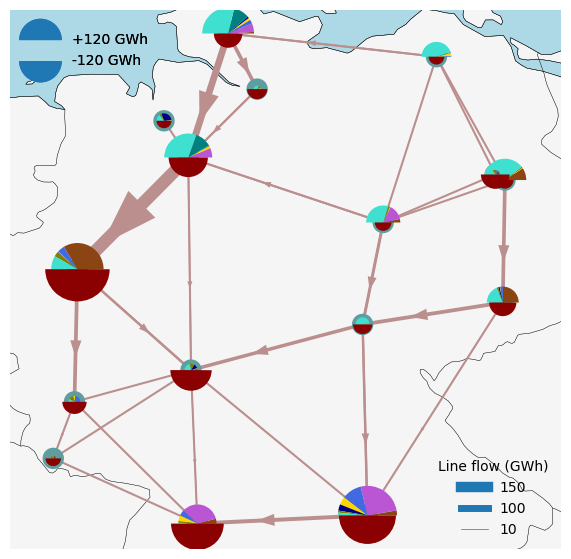

In [43]:
add_legend_semicircles(
    ax,
    sizes=[bus/bus_size_factor for bus in [120000,-120000]],
    labels=["+120 GWh", "-120 GWh"],
    legend_kw={
        "loc": "upper left", 
        "frameon": False, 
        "bbox_to_anchor": (0.02, 0.98),
    },
)
fig

To add legend entries for each bus carrier, we use `add_legend_patches`.

In [44]:
nc.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
name,,,,,
Pumped Hydro,0.0,cornflowerblue,,inf,0.0
Gas,0.0,darkorange,,inf,0.0
Brown Coal,0.0,saddlebrown,,inf,0.0
Nuclear,0.0,mediumorchid,,inf,0.0
Wind Onshore,0.0,turquoise,,inf,0.0
Run of River,0.0,royalblue,,inf,0.0
Oil,0.0,peru,,inf,0.0
Storage Hydro,0.0,navy,,inf,0.0
Multiple,0.0,pink,,inf,0.0


In [45]:
nc.carriers.index

Index(['Pumped Hydro', 'Gas', 'Brown Coal', 'Nuclear', 'Wind Onshore',
       'Run of River', 'Oil', 'Storage Hydro', 'Multiple', 'Other',
       'Geothermal', 'Solar', 'AC', 'Wind Offshore', 'Hard Coal', 'Waste', '',
       '-'],
      dtype='object', name='name')

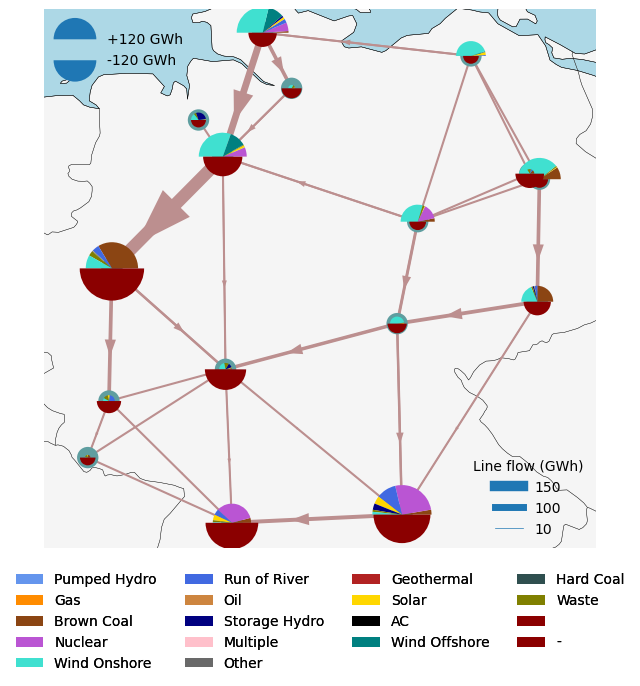

In [46]:
add_legend_patches(
    ax,
    colors=list(nc.carriers.color),     # colors
    labels=list(nc.carriers.index),     # labels
    legend_kw={
        "loc": "lower center",
        "bbox_to_anchor": (0.5, -0.25), # For offsetting
        "ncol": 4,
        "frameon": False,
    }
)

fig


### Exporting

We can export the figure to any desired format, i.e., `.png`, `.jpg`, `.pdf` etc.

In [41]:
fig.savefig("static-plot.jpg", dpi=150)